# NeuroNLP - new experiments

In [1]:
from gensim.models.word2vec import Word2Vec  
from gensim.models import KeyedVectors 
from gensim.test.utils import datapath
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
from tqdm import tqdm
from copy import deepcopy
import pickle as plk
import torch
import time
import re
import os
import math
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from wandb.keras import WandbCallback
import wandb
from tensorflow.keras.losses import mean_squared_error

In [2]:
is_linux = False

# File separator:
if is_linux:
    s = "/"  # linux
else:
    s = "\\" # windows

path_to_data = "data" + s
#path_to_NLP = "NLP" + s
path_to_w2v = "word2vec" + s
path_to_results = "NLP_results" +s

## Load data

In [3]:
def read_data(fname):
    with open(fname, "r", encoding="UTF-8") as f:
        data = [line.rstrip().split(' ') for line in f.readlines()]
    df = pd.DataFrame(data = data)
    if len(df.columns) == 2:
        df.columns = ['x', 'y']
        for col in df.columns:
            df[col] = df[col].astype('float32')
    else:
        for col in df.columns:
            df[col] = df[col].astype('int64')        
    return df

## Preprocessing 

In [4]:
def make_sents(dfx, locs, window_size, step, repetitions, do_shuffle): # window size - No of 20 ms intervals 
    sents = []
    spikes = [] # for comparison
    start, end = 0, window_size
    empty_windows = 0
    x_new, y_new = [], []
    x, y = locs['x'], locs['y']
    
    while end < len(dfx):
        
        # Sentences: 
        rows = dfx.iloc[start:end] # rows in window
        row = np.sum(rows) # all spikes of each neuron in window
        sent_words = []
        
        if np.sum(row)==0:
            empty_windows+=1
            sents.append(sent_words)
        else: # if there were any spikes at all
            for j, spike_count in enumerate(row):
                if spike_count!=0:
                    if repetitions==True:                    
                        sent_words+=[row.index[j] for x in range(spike_count)]                             
                    else:
                        sent_words.append(row.index[j])
            if do_shuffle==True:
                shuffle(sent_words)
            sents.append(sent_words)         
        
        # Spikes:
        spikes.append(row.tolist())    
            
        # Locations:
        if window_size==1:
            loc_x, loc_y = x[start], y[start]
        elif window_size%2==0: # even number
            loc_ind = int(start+(window_size)/2)
            loc_ind2 =  loc_ind-1
            loc_x = (x[loc_ind] + x[loc_ind2])/2
            loc_y = (y[loc_ind] + y[loc_ind2])/2
        else: # odd number
            loc_ind = int(start+(window_size-1)/2)
            loc_x, loc_y = x[loc_ind], y[loc_ind]
        x_new.append(loc_x)
        y_new.append(loc_y)
        start+=step
        end+=step
     
    locs2 = pd.DataFrame(data=[x_new, y_new]).T
    locs2.columns = ['x', 'y']   
    
    return [sents, locs2, empty_windows, spikes] 

## Analysis of goodness of windows

How many empty and total sentences with different window size and step?

In [5]:
def analyse_windows(dfx, locations2, window_sizes, steps, repetitions):
    for i in range(len(steps)):
        window_size = window_sizes[i]
        step = steps[i]
        
        sents, locations3, empty_windows, spikes = make_sents(dfx, locations2, window_size=window_size, step=step, repetitions=repetitions, do_shuffle=False)
        sent_lens = pd.Series([len(s) for s in sents]).value_counts()
        print('\nwindow_size=', window_size, '(', window_size*20,'ms)', 'step=', step, '(', step*20,'ms)')
        print('empty windows: ', empty_windows, 'out of', len(sents), '(', round(100*empty_windows/(len(sents)), 2),'%), non-empty:', len(sents)-empty_windows)
        print(sent_lens)
        
# window_sizes = [30, 30, 30]
# steps = [5, 10, 15]
# analyse_windows(df, locations2, window_sizes, steps, repetitions=False)

# window_sizes = [30, 40, 50]
# steps = [15, 20, 25]
# analyse_windows(df, locations2, window_sizes, steps, repetitions=False)

# window_sizes = [60, 70, 80]
# steps = [30, 35, 40]
# analyse_windows(df, locations2, window_sizes, steps, repetitions=False)

## Calculate weights for neurons

Weight depends on how disperse or compact is the neuron's receptive field. Neurons with disperse fields receive lower weight in sentence, and those with more compact receptive field receive larger weight.

In [6]:
def calc_weights(dfx, locations2x, avg_loc):
    
    # Calculate centroid of each receptive field:
    neurons = dfx.columns.tolist()
    df_all = pd.concat([dfx, locations2x], axis=1)
    centroids_x, centroids_y = [], []
    centroids_y= []
    spike_times = []
    for neuron in neurons:
        d = df_all[df_all[neuron]>0]
        # d = df_all[df_all['42']>0]
        spike_times.append(len(d))
        if len(d)==0:  # if neuron didn't spike, assume it's centroid to be the default average location
            centroids_x.append(avg_loc[0])
            centroids_y.append(avg_loc[1])
        else:
            d = d[[neuron, 'x', 'y']]
            centroids_x.append(np.sum(d[neuron]*d['x'])/np.sum(d[neuron]))
            centroids_y.append(np.sum(d[neuron]*d['y'])/np.sum(d[neuron]))
    df_centroids = pd.DataFrame(data = [neurons, centroids_x, centroids_y, spike_times]).T
    df_centroids.columns = ['neuron', 'x', 'y', 'spike_times']
    df_centroids.index = neurons
    
    # Average distance of spike locations to centroid:
    means = []
    st_devs = []
    for neuron in neurons:
        d = df_all[df_all[neuron]>0]
        if len(d)==0: 
            means.append(45.0) # to have the missing neuron have very low weight
            st_devs.append(30.0)   # stdev is now not actually used...    
        else:
            d = d[[neuron, 'x', 'y']]
            # centroid = df_centroids.iloc[int(neuron)]
            centroid = df_centroids.loc[neuron]
            dists = np.sqrt((d['x']-centroid['x'])**2+(d['y']-centroid['y'])**2)
            avg_dist = np.mean(dists)  
            stdev_dists = np.std(dists)
            # plt.hist(dists, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
            # plt.xlim(0,110)
            means.append(avg_dist)
            st_devs.append(stdev_dists) 
    dists_df = pd.DataFrame(data = [means, st_devs, spike_times]).T
    dists_df.columns = ['avg_dist', 'std_dist', 'spike_times']
    # plt.plot(sorted(dists_df['avg_dist']))
    
    dists_df.index = pd.Series(neurons).astype('int64')
    
    # Scale the distances:
    a = np.max(means)-means # inverse # 0- worst, 33.3- best
    # plt.plot(sorted(a)) # 
    a2 = (a/np.max(a))+0.1  # to avoid zero 
    
    # TODO: When assigning weights, take better into account how many times the neuron 
    # spiked - if it spiked only a few times, its weight should be lower (because then 
    # we have less confidence that in future it will spike in similar locations). 
    # - For now, just multiply weight by 0.9 if there were less than 10 spikes:
    b = pd.Series(spike_times)<10
    a2 = pd.Series(a2).where(-b, a2*0.9) 

    dists_df['weight'] = a2    
    dists_df['weight^3'] = a2**3 # to give more weight to more compact receptive fields
    dists_df['w+2*w^3']=dists_df['weight'] + dists_df['weight^3']*2 
    
    # plt.plot(sorted(dists_df['weight'] ))
    # plt.plot(sorted(dists_df['weight^3'] ))    
    # plt.plot(sorted(dists_df['w+2*w^3']))

    return dists_df

# dists_df = calc_weights(df, locations2)

## Train/test

In [7]:
def make_train_test(sents, locs2, spikes, train_index, test_index, dfx, locations2, 
                    win_size, step, rep, do_shuffle, remove_duplicates, fold):
        
    test_locs_tmp = locs2.iloc[test_index]
    train_locs_tmp = locs2.iloc[train_index]
    test_sents_tmp = pd.Series(sents).iloc[test_index].tolist()
    train_sents_tmp = pd.Series(sents).iloc[train_index].tolist()
    test_spikes_tmp = pd.Series(spikes).iloc[test_index].tolist()
    train_spikes_tmp =pd.Series(spikes).iloc[train_index].tolist()

    # Average location in train set (for predicting empty rows in test set):
    avg_loc = [np.mean(train_locs_tmp['x']), np.mean(train_locs_tmp['y'])]
    
    # Calculate weights for neurons, based on train set:
    # -Those indexes are based on 1/10 parts of the original dataframe (the one 
    #containing the sentences is already shorter, because we aggregated data in each window.
    split_size = int(len(dfx)/10)  # 5410
    if fold==0:
        start = split_size
        end =  len(dfx)
        dists_df = calc_weights(dfx.iloc[start:end], locations2.iloc[start:end], avg_loc)
    elif fold==9:
        start = 0
        end = len(dfx) - split_size
        dists_df = calc_weights(dfx.iloc[start:end], locations2.iloc[start:end], avg_loc)
    else: 
        start = 0
        end = fold*split_size
        start2 = fold*split_size + split_size
        end2 = len(dfx)
        dfx_part1 = dfx.iloc[start:end]
        dfx_part2 = dfx.iloc[start2:end2]
        locs_part1 = locations2.iloc[start:end]
        locs_part2 = locations2.iloc[start2:end2]    
        dfx_parts_all = dfx_part1.append(dfx_part2, sort = False) 
        locs_parts_all = locs_part1.append(locs_part2, sort = False) 
        dists_df = calc_weights(dfx_parts_all, locs_parts_all, avg_loc)
    
    # Separate empty rows and their locations from test set:
    # - (they will be put back before calculating RMSE)
    x_new, y_new, test_sents, test_spikes = [], [], [], []
    x_new_empty, y_new_empty = [], []
    x, y = test_locs_tmp['x'], test_locs_tmp['y']
    loc_ids = x.index.tolist()
    for i, sent in enumerate(test_sents_tmp):
        if len(sent)!=0:
            test_sents.append(sent)
            test_spikes.append(test_spikes_tmp[i])
            x_new.append(x[loc_ids[i]])
            y_new.append(y[loc_ids[i]])
        else:
            x_new_empty.append(x[loc_ids[i]])
            y_new_empty.append(y[loc_ids[i]])
    
    test_locs_empty = pd.DataFrame(data=[x_new_empty, y_new_empty]).T
    test_locs_empty.columns = ['x', 'y']
    test_locs = pd.DataFrame(data=[x_new, y_new]).T
    test_locs.columns = ['x', 'y']
        

    # If there is same sentence in consequtive windows, leave only one such sentence, 
    #and average the location (this occurs because of moving window: if 20ms intervals 
    #at the edges of the window were empty, same sentence was included several times)
    #- ONLY MAKES SENCE IF "DO_SHUFFLE" = False. BUT ACTUALLY, SINCE WE SHUFFLE, THIS 
    #HAS BECOME USELESS...
    if remove_duplicates==True:
        x_new, y_new, train_sents2, train_spikes2 = [], [], [], []
        x, y = train_locs_tmp['x'], train_locs_tmp['y']
        prev_x, prev_y = [], []
        prev_sent = ['']
        for i, sent in enumerate(train_sents_tmp):
            x_current, y_current = x[i], y[i]
            if sent==prev_sent:
                prev_x.append(x_current)
                prev_y.append(y_current)                                   
            else:
                if i!=0:
                    train_sents2.append(prev_sent)
                    train_spikes2.append(train_sents_tmp[i-1])
                    x_new.append(np.mean(np.array(prev_x)))
                    y_new.append(np.mean(np.array(prev_y)))
                prev_x, prev_y = [x_current], [y_current]
                prev_sent = sent 
            if i==len(train_sents_tmp):
                train_sents2.append(sent)
                train_spikes2.append(train_sents_tmp[i])
                x_new.append(np.mean(np.array(prev_x)))
                y_new.append(np.mean(np.array(prev_y)))             
                
        train_locs2 = pd.DataFrame(data=[x_new, y_new]).T
        train_locs2.columns = ['x', 'y']
    else:
        train_locs2 = train_locs_tmp
        train_sents2 = train_sents_tmp
        train_spikes2 = train_spikes_tmp
    
    # Exclude remaining empty sentences from train:
    x_new, y_new, train_sents3, train_spikes3 = [], [], [], []
    x, y = train_locs2['x'].tolist(), train_locs2['y'].tolist()
    for i, sent in enumerate(train_sents2):
        if len(sent)!=0:
            train_sents3.append(sent)
            train_spikes3.append(train_spikes2[i])
            x_new.append(x[i])
            y_new.append(y[i])
    
    train_locs3 = pd.DataFrame(data=[x_new, y_new]).T
    train_locs3.columns = ['x', 'y']
    
    
    return [test_locs, test_locs_empty, test_sents, train_locs3, train_sents3, 
            train_spikes3, test_spikes, avg_loc, dists_df]


## Word2vec

In [8]:
class my_callback(CallbackAny2Vec): # to print loss after each epoch
    def __init__(self, model, epochs, model_path, s): 
        self.epoch = 1
        self.tot_epochs = epochs
        self.loss_previous_step=0
        self.model_path = model_path
        self.best_model = model
        self.best_epoch = 1
        self.best_loss = 1000000
        self.s = s
        
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 1:
            print("Training word2vec for " + str(self.tot_epochs) + " epochs...")
            current_loss = loss
        else:
            current_loss = loss-self.loss_previous_step # loss is cumulative
            
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_model  = model
            self.best_epoch = self.epoch
            # print("Epoch " + str(self.epoch)+ ": loss: " + str(round(current_loss, 6)))
            
        # Last epoch:
        if self.epoch == self.tot_epochs:
            self.best_model.save(self.model_path + self.s + "word2vec.model")  
            print("word2vec best epoch: " +  str(self.best_epoch) + ", loss: "+ str(round(self.best_loss, 6)))
            
        self.epoch+= 1
        self.loss_previous_step = loss  
         

def make_wordvec_model(train_sents, vec_len, window_size, skipgram, batch_size, epochs, s, path_to_w2v):

    model = Word2Vec(min_count=1, vector_size=vec_len, window=window_size, max_vocab_size=None,
                     max_final_vocab=None, sg = skipgram,  compute_loss= True, batch_words=batch_size)

    # Build vocabulary:
    model.build_vocab(train_sents)
    # a = model.wv.key_to_index
    sent_counts = len(train_sents)
    
    # Train with callback:
    model.train(corpus_iterable = train_sents, total_examples=sent_counts,
                epochs=epochs, compute_loss=True, callbacks=[my_callback(model, epochs, path_to_w2v, s)]) 
        
    return model

In [15]:
# For standardizing the input (needed especially for LSTM, but also important 
#for logistic regression; Random Forest doesn't care much):
def standardize_col(col_train, col_test):
    m = np.mean(col_train)
    stdev = np.std(col_train)
    col2_train = (col_train-m)/stdev
    col2_test = (col_test-m)/stdev   
    return [col2_train, col2_test]


def make_vecs(model, neurons, train_sents, test_sents, train_spikes, test_spikes, 
              train_locs, test_locs, dists_df, use_weights):      

    weight_col = dists_df['w+2*w^3'] # 'w+2*w^3', '5*(w+w^3)' # 'w+w^2+w^3'  'w+w^3' #  
    #  '3*(w+w^3)' # '5*(w+w^3)'  # 'w+5*w^3' # 'w+3*w^3' #'7*(w+w^3)' #  
    # '10*(w+w^3)' # '0.5*w+2*w^3',
     
    #-------------------------------------------------    
    # Sentences:
    
    # Average vectors of each sentence:
    train_vecs, test_vecs = [], [] # both train and test

    weight_col.index = weight_col.index.astype('str')
    for sent in train_sents:
        # sent = train_sents[0]
        vecs = [model.wv[code] for code in sent]
        
        # simple average:
        if use_weights==False: # simple average
            train_vecs.append(np.mean(np.array(vecs), axis = 0)) 
            
        # weighted average:
        else: 
            weights = [weight_col.loc[sent[x]] for x in range(len(sent))]
            vecs = vecs*np.array(weights).reshape(len(weights),1)
            train_vecs.append(np.mean(vecs, axis=0))
            
    for sent in test_sents:
        vecs = [model.wv[code] for code in sent]
        
        # simple average:
        if use_weights==False: # simple average
            test_vecs.append(np.mean(np.array(vecs), axis = 0)) 
            
        # weighted average:
        else: 
            weights = [weight_col.loc[sent[x]] for x in range(len(sent))]
            vecs = vecs*np.array(weights).reshape(len(weights),1)
            test_vecs.append(np.mean(vecs, axis=0))
        
    df_train = pd.DataFrame(data=train_vecs)
    df_test = pd.DataFrame(data=test_vecs)

    # Normalize:
    for col in df_train.columns.tolist():
        train_col, test_col = standardize_col(df_train[col], df_test[col])
        df_train[col] = train_col
        df_test[col] = test_col 

    #-------------------------------------------------    
    # Locations:
    train_y = train_locs
    test_y = test_locs

    #-------------------------------------------------
    
    # Spikes:
    df_train_spikes = pd.DataFrame(data=train_spikes)
    df_test_spikes = pd.DataFrame(data=test_spikes)

    # Not sure if multiplying each feature by some weight gives any effect...
    if use_weights==True:
        df_train_spikes = np.true_divide(df_train_spikes, weight_col.tolist()) 
        df_test_spikes = np.true_divide(df_test_spikes, weight_col.tolist()) 
    
    # Normalize:
    for col in df_train_spikes.columns.tolist():
        train_col, test_col = standardize_col(df_train_spikes[col], df_test_spikes[col])
        df_train_spikes[col] = train_col
        df_test_spikes[col] = test_col 
    
    
    return [train_vecs, test_vecs, df_train, df_test, train_y, test_y, df_train_spikes, df_test_spikes]



def get_predictions(reg_model, df_train2, train_y, df_test2, test_y, avg_loc, test_locs_empty, test_sents):
    reg_model = reg_model.fit(df_train2, train_y)
    
    # Predictions (also add back intervals with no spikes, for which we always predict average 
    #location of rat in train set):
    preds = reg_model.predict(df_test2)  
    preds_df = pd.DataFrame(preds)
    preds_avg_x = [avg_loc[0] for x in range(len(test_locs_empty))]
    preds_avg_y = [avg_loc[1] for x in range(len(test_locs_empty))]
    empty_preds_df = pd.DataFrame(data = [preds_avg_x, preds_avg_y]).T
    preds_df = preds_df.append(empty_preds_df, ignore_index=True, sort = False) 
    preds_df.columns=['x', 'y']
    
    # Actuals for emptys:
    emptys_count = len(test_locs_empty)
    if emptys_count!=0:
        test_y = test_y.append(test_locs_empty, ignore_index=True, sort = False)
        
    if len(test_sents)!=0:  # only for sentences (not spikes)
        test_sents2 = deepcopy(test_sents)
        if emptys_count!=0:
            for i in range(emptys_count):
                test_sents2.append([])

    
    # Distance between predicted and actual location:
    dists = np.sqrt((test_y['x'] - preds_df['x'])**2 + (test_y['y'] -preds_df['y'])**2)
    avg_dist_te = np.mean(dists)   
    # print('test:', avg_dist_te, end = ', ')
    
    # Predictions for train: (doesn't include possible empty rows)
    preds2 = reg_model.predict(df_train2)  
    preds_df2 = pd.DataFrame(preds2)
    preds_df2.columns=['x', 'y']
    dists2 = np.sqrt((train_y['x'] - preds_df2['x'])**2 + (train_y['y'] -preds_df2['y'])**2)
    avg_dist_tr = np.mean(dists2)   
    # print('train:', avg_dist_tr)
    
    # Results as df:
    df_preds = pd.DataFrame(data = [test_y['x'].tolist(), test_y['y'].tolist(), preds_df['x'].tolist(), 
                                    preds_df['y'].tolist(), dists.tolist()]).T
    df_preds.columns = ['x', 'y', 'pred_x', 'pred_y', 'dist']
        
    # Sentence lengths - only for sentences (not spikes):
    if len(test_sents)!=0:
        sent_lengths = [len(sent) for sent in test_sents2]
        df_preds['sent']= test_sents2  
        df_preds['length']= sent_lengths
        df_preds = df_preds[['sent', 'length', 'x', 'y', 'pred_x', 'pred_y', 'dist']]
    
    return [df_preds, avg_dist_te, avg_dist_tr]

# Load data:

In [9]:
# 5410 steps:
locations = read_data(path_to_data + "R2192_1x200_at5_step200_bin100-RAW_pos.dat")

# 54100 steps:
locations2 = pd.read_csv(path_to_data + "R2192_20ms_speed_direction.csv", encoding = "UTF-8") 
locations2 =locations2.drop(columns= ['speed', 'direction', 'direction_disp'])

# rescale locations2 so that they are the same as locations (1mx1m):
x_factor = locations.iloc[0]['x']/np.mean(locations2[:10]['x'])
y_factor = locations.iloc[0]['y']/np.mean(locations2[:10]['y'])
locations2['x'] = locations2['x']*x_factor
locations2['y'] = locations2['y']*y_factor

# Spikes:
fn = "R2192_20ms_63_neurons.csv" # 63 rows, 54100 cols
df =  pd.read_csv(path_to_data + fn, encoding = "UTF-8", header=None) 
df = df.T

# Neuron ids:
neurons = [str(x) for x in range(63)]
df.columns = neurons

**Input parameters:**

In [10]:
window_size = 60 #60 # 50      # # window_size = 10 -> 200ms, window_size = 60 -> 1200ms  
step =  7 # 7 # 10 # 3 # 10
do_shuffle= True # TRUE!  
repetitions = True # TRUE!
rm_duplicates = False # # FALSE! (doesn't make sence if do_shuffle=True)
data = df #
w2v_vec_len= 125 # 250
w2v_win_size = 7 # 6 # 5 #10 #10 # 5
w2v_skipgram=0
w2v_batch_size= 500 #500 # 500 - ok with non-augmented train data
w2v_epochs= 600 # 600- good with non-augmented train data
use_weights = True # use weighted average instead of simple average when combining neuron vectors into sentence

**Sentences, spikes and locations:**

In [11]:
window_data = make_sents(df, locations2, window_size, step,  repetitions, do_shuffle)
sents, locs2, spikes = window_data[0], window_data[1], window_data[3]

## 10-fold cross-validation with simple models (linear regression, random forest and knn)

Here, we will make train/test splits simultaneously for spike counts data and word vectors data, in order to ensure that they are exactly comparable (same window size, shift in moveing the window etc.)

After preparing train/test data for spike counts and word vectors for current fold, three simple models are trained and evaluated on both types of data. We gather resuts of all folds, so that they can be later aggregated, saved and analysed.

In [20]:
#10-fold cv rmse-s:
rmses_knn_spikes = [] #[[fold1_te, fold1_tr], [fold2_te, fold2_tr], ...]
rmses_knn_sent = []
rmses_linreg_spikes = []
rmses_linreg_sent = []
rmses_rf_spikes = []
rmses_rf_sent = []

# Predictions for test:
pred_knn_spikes, pred_rf_spikes, pred_linreg_spikes = [], [], []
pred_knn_sents, pred_rf_sents, pred_linreg_sents = [], [], []
 #[fold1_df_pred, fold2_df_pred ...] # not strictly needed, just interesting to compare what was predicted...

In [21]:
kf = KFold(n_splits=10, shuffle = False)
kfold  = kf.split(sents)  

for fold in tqdm(range(0,10)):

    # Indexes of this fold:
    train_index, test_index = next(kfold) # kfold is generator object
    
    print('\nFOLD = ', fold, ':')
    
    # if fold!=9:
    #     continue
    #if fold==1:
    #    break
    
    #PREPARE DATA FOR THIS FOLD: 
        
    print('preparing data...')
    result2 = make_train_test(sents, locs2, spikes, train_index, test_index, data, locations2, window_size, step, repetitions, do_shuffle, rm_duplicates, fold)
    test_locs, test_locs_empty, test_sents = result2[0], result2[1], result2[2]
    train_locs, train_sents = result2[3], result2[4]
    train_spikes, test_spikes = result2[5], result2[6]
    avg_loc, dists_df = result2[7], result2[8]
    print('Min spikes of neuron:', int(np.min(dists_df['spike_times'])))
    
    # Make word2vec model: ONLY SENTS:
    model = make_wordvec_model(train_sents, w2v_vec_len, w2v_win_size, w2v_skipgram, w2v_batch_size, w2v_epochs, s, path_to_w2v) # last model (might not be best)
    model = Word2Vec.load(path_to_w2v + s + "word2vec.model") # laod best model      
    
    # Make vectors (only for sentences), and prepare (weighted) train/test dfs (for sents and spikes):
    result = make_vecs(model, neurons, train_sents, test_sents, train_spikes, test_spikes, train_locs, test_locs, dists_df, use_weights)
    train_vecs, test_vecs = result[0], result[1]
    df_train, df_test= result[2], result[3]
    df_train_spikes, df_test_spikes= result[6], result[7]  # pmst: trainX, testX
    train_y, test_y = result[4], result[5]

    # --------------------------------------------------
    
    # REGRESSION MODELS:
        
    print('\nRMSEs of models with spikes (fold=', fold, '):')
    # - Spikes, linear regression:
    reg_model = MultiOutputRegressor(LinearRegression()) 
    df_preds, rmse_te, rmse_tr = get_predictions(reg_model, df_train_spikes, train_y, df_test_spikes, test_y, avg_loc, test_locs_empty, []) 
    rmses_linreg_spikes.append([rmse_te, rmse_tr])
    pred_linreg_spikes.append(df_preds)
    print('Linear regression: test:', round(rmse_te, 6), ', train:', round(rmse_tr, 6))

    # - Spikes, knn:
    reg_model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=30)) 
    df_preds, rmse_te, rmse_tr = get_predictions(reg_model, df_train_spikes, train_y, df_test_spikes, test_y, avg_loc, test_locs_empty, []) 
    rmses_knn_spikes.append([rmse_te, rmse_tr])
    pred_knn_spikes.append(df_preds)
    print('KNN: test:', round(rmse_te, 6), ', train:', round(rmse_tr, 6))
        
    # - Spikes, Random Forest:
    reg_model = MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=15, n_jobs=6)) 
    df_preds, rmse_te, rmse_tr = get_predictions(reg_model, df_train_spikes, train_y, df_test_spikes, test_y, avg_loc, test_locs_empty, [])   
    rmses_rf_spikes.append([rmse_te, rmse_tr])
    pred_rf_spikes.append(df_preds)
    print('Random Forest: test:', round(rmse_te, 6), ', train:', round(rmse_tr, 6))
    
    # ----------------------------------------------
    
    print('\nRMSEs of models with sentences (fold=', fold, '):')
    # - Sentences, linear regression:
    reg_model = MultiOutputRegressor(LinearRegression())  # 20 
    df_preds, rmse_te, rmse_tr = get_predictions(reg_model, df_train, train_y, df_test, test_y, avg_loc, test_locs_empty, test_sents)
    rmses_linreg_sent.append([rmse_te, rmse_tr])
    pred_linreg_sents.append(df_preds)
    print('Linear regression: test:', round(rmse_te, 6), ', train:', round(rmse_tr, 6))
        
    # - Sentences, knn:    
    reg_model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=30))  # 20 
    df_preds, rmse_te, rmse_tr = get_predictions(reg_model, df_train, train_y, df_test, test_y, avg_loc, test_locs_empty, test_sents)
    rmses_knn_sent.append([rmse_te, rmse_tr])
    pred_knn_sents.append(df_preds)
    print('KNN: test:', round(rmse_te, 6), ', train:', round(rmse_tr, 6))
        
    # - Sentences, Random Forest:     
    reg_model = MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=5, n_jobs=6)) 
    df_preds, rmse_te, rmse_tr = get_predictions(reg_model, df_train, train_y, df_test, test_y, avg_loc, test_locs_empty, test_sents)
    rmses_rf_sent.append([rmse_te, rmse_tr])
    pred_rf_sents.append(df_preds)
    print('Random Forest: test:', round(rmse_te, 6), ', train:', round(rmse_tr, 6))
    
    print('---------------------------------------------')

  0%|                                                      | 0/10 [00:00<?, ?it/s]


FOLD =  0 :
preparing data...
Min spikes of neuron: 50
Training word2vec for 600 epochs...
word2vec best epoch: 502, loss: 34250.0

RMSEs of models with spikes (fold= 0 ):
Linear regression: test: 20.431549 , train: 21.189604
KNN: test: 19.539865 , train: 14.456217
Random Forest: test: 17.382597 , train: 10.462742

RMSEs of models with sentences (fold= 0 ):
Linear regression: test: 19.574364 , train: 17.894156
KNN: test: 17.124585 , train: 13.340722


 10%|████▌                                        | 1/10 [05:21<48:13, 321.51s/it]

Random Forest: test: 16.185198 , train: 5.031567
---------------------------------------------

FOLD =  1 :
preparing data...
Min spikes of neuron: 40
Training word2vec for 600 epochs...
word2vec best epoch: 565, loss: 32488.0

RMSEs of models with spikes (fold= 1 ):
Linear regression: test: 29.602144 , train: 20.185006
KNN: test: 27.643017 , train: 13.89607
Random Forest: test: 23.171943 , train: 10.147747

RMSEs of models with sentences (fold= 1 ):
Linear regression: test: 25.334749 , train: 17.180493
KNN: test: 20.767453 , train: 12.790796


 20%|█████████                                    | 2/10 [09:59<39:28, 296.04s/it]

Random Forest: test: 21.422424 , train: 4.890472
---------------------------------------------

FOLD =  2 :
preparing data...
Min spikes of neuron: 51
Training word2vec for 600 epochs...
word2vec best epoch: 578, loss: 33730.0

RMSEs of models with spikes (fold= 2 ):
Linear regression: test: 23.152341 , train: 20.875644
KNN: test: 21.941902 , train: 14.268738
Random Forest: test: 18.807435 , train: 10.565072

RMSEs of models with sentences (fold= 2 ):
Linear regression: test: 19.347183 , train: 17.898317
KNN: test: 15.515027 , train: 13.303761


 30%|█████████████▌                               | 3/10 [15:17<35:42, 306.05s/it]

Random Forest: test: 15.192764 , train: 5.006104
---------------------------------------------

FOLD =  3 :
preparing data...
Min spikes of neuron: 53
Training word2vec for 600 epochs...
word2vec best epoch: 540, loss: 33388.0

RMSEs of models with spikes (fold= 3 ):
Linear regression: test: 18.77629 , train: 21.364541
KNN: test: 16.755504 , train: 14.543038
Random Forest: test: 15.416415 , train: 10.686651

RMSEs of models with sentences (fold= 3 ):
Linear regression: test: 18.474158 , train: 18.007219
KNN: test: 16.518461 , train: 13.293221


 40%|██████████████████                           | 4/10 [20:44<31:24, 314.15s/it]

Random Forest: test: 15.608201 , train: 5.064911
---------------------------------------------

FOLD =  4 :
preparing data...
Min spikes of neuron: 52
Training word2vec for 600 epochs...
word2vec best epoch: 458, loss: 32910.0

RMSEs of models with spikes (fold= 4 ):
Linear regression: test: 23.906306 , train: 20.771098
KNN: test: 18.928353 , train: 14.594459
Random Forest: test: 17.764954 , train: 10.475315

RMSEs of models with sentences (fold= 4 ):
Linear regression: test: 20.496319 , train: 17.793561
KNN: test: 17.252656 , train: 13.40274


 50%|██████████████████████▌                      | 5/10 [26:04<26:21, 316.39s/it]

Random Forest: test: 16.898736 , train: 5.116307
---------------------------------------------

FOLD =  5 :
preparing data...
Min spikes of neuron: 54
Training word2vec for 600 epochs...
word2vec best epoch: 589, loss: 33674.0

RMSEs of models with spikes (fold= 5 ):
Linear regression: test: 21.518254 , train: 21.052473
KNN: test: 17.575196 , train: 14.499132
Random Forest: test: 14.378969 , train: 10.685602

RMSEs of models with sentences (fold= 5 ):
Linear regression: test: 16.940875 , train: 18.132548
KNN: test: 14.704895 , train: 13.3963


 60%|███████████████████████████                  | 6/10 [31:29<21:17, 319.42s/it]

Random Forest: test: 13.276003 , train: 5.033866
---------------------------------------------

FOLD =  6 :
preparing data...
Min spikes of neuron: 52
Training word2vec for 600 epochs...
word2vec best epoch: 513, loss: 32494.0

RMSEs of models with spikes (fold= 6 ):
Linear regression: test: 23.27851 , train: 20.834402
KNN: test: 18.845983 , train: 14.514744
Random Forest: test: 15.909015 , train: 10.517533

RMSEs of models with sentences (fold= 6 ):
Linear regression: test: 19.357186 , train: 17.868674
KNN: test: 16.024805 , train: 13.497019


 70%|███████████████████████████████▍             | 7/10 [36:12<15:22, 307.42s/it]

Random Forest: test: 15.759884 , train: 5.126048
---------------------------------------------

FOLD =  7 :
preparing data...
Min spikes of neuron: 39
Training word2vec for 600 epochs...
word2vec best epoch: 556, loss: 32634.0

RMSEs of models with spikes (fold= 7 ):
Linear regression: test: 21.952731 , train: 20.98632
KNN: test: 18.672924 , train: 14.355862
Random Forest: test: 17.646732 , train: 10.561317

RMSEs of models with sentences (fold= 7 ):
Linear regression: test: 17.913279 , train: 18.049944
KNN: test: 16.458605 , train: 13.399604


 80%|████████████████████████████████████         | 8/10 [40:54<09:58, 299.33s/it]

Random Forest: test: 15.924623 , train: 5.029823
---------------------------------------------

FOLD =  8 :
preparing data...
Min spikes of neuron: 49
Training word2vec for 600 epochs...
word2vec best epoch: 570, loss: 32076.0

RMSEs of models with spikes (fold= 8 ):
Linear regression: test: 26.974177 , train: 20.959255
KNN: test: 24.236421 , train: 14.455861
Random Forest: test: 21.2514 , train: 10.560544

RMSEs of models with sentences (fold= 8 ):
Linear regression: test: 23.168497 , train: 17.818518
KNN: test: 21.559098 , train: 13.249714


 90%|████████████████████████████████████████▌    | 9/10 [45:59<05:01, 301.06s/it]

Random Forest: test: 19.137925 , train: 5.02258
---------------------------------------------

FOLD =  9 :
preparing data...
Min spikes of neuron: 33
Training word2vec for 600 epochs...
word2vec best epoch: 483, loss: 32596.0

RMSEs of models with spikes (fold= 9 ):
Linear regression: test: 22.749035 , train: 20.964748
KNN: test: 21.493921 , train: 14.386808
Random Forest: test: 19.664105 , train: 10.563522

RMSEs of models with sentences (fold= 9 ):
Linear regression: test: 18.72949 , train: 17.988179
KNN: test: 17.813383 , train: 13.450544


100%|████████████████████████████████████████████| 10/10 [48:51<00:00, 293.19s/it]

Random Forest: test: 16.396162 , train: 5.083835
---------------------------------------------


### All results:

In [22]:
rmses = [rmses_linreg_spikes, rmses_knn_spikes, rmses_rf_spikes, rmses_linreg_sent, rmses_knn_sent, rmses_rf_sent]
cols = ['linreg_spikes', 'knn_spikes', 'rf_spikes', 'linreg_sents', 'knn_sents', 'rf_sents']
df_rmse_te = pd.DataFrame()
df_rmse_tr = pd.DataFrame()
for i, model_rmses in enumerate(rmses):
    model_rmses = pd.DataFrame(data = model_rmses)
    df_rmse_te[cols[i]] = model_rmses[0]
    df_rmse_tr[cols[i]] = model_rmses[1]    

Test results:

In [23]:
df_rmse_te

,linreg_spikes,knn_spikes,rf_spikes,linreg_sents,knn_sents,rf_sents
0,20.431549,19.539865,17.382597,19.574364,17.124585,16.185198
1,29.602144,27.643017,23.171943,25.334749,20.767453,21.422424
2,23.152341,21.941902,18.807435,19.347183,15.515027,15.192764
3,18.776290,16.755504,15.416415,18.474158,16.518461,15.608201
4,23.906306,18.928353,17.764954,20.496319,17.252656,16.898736
5,21.518254,17.575196,14.378969,16.940875,14.704895,13.276003
6,23.278510,18.845983,15.909015,19.357186,16.024805,15.759884
7,21.952731,18.672924,17.646732,17.913279,16.458605,15.924623
8,26.974177,24.236421,21.251400,23.168497,21.559098,19.137925
9,22.749035,21.493921,19.664105,18.729490,17.813383,16.396162


Train results:

In [24]:
df_rmse_tr

,linreg_spikes,knn_spikes,rf_spikes,linreg_sents,knn_sents,rf_sents
0,21.189604,14.456217,10.462742,17.894156,13.340722,5.031567
1,20.185006,13.896070,10.147747,17.180493,12.790796,4.890472
2,20.875644,14.268738,10.565072,17.898317,13.303761,5.006104
3,21.364541,14.543038,10.686651,18.007219,13.293221,5.064911
4,20.771098,14.594459,10.475315,17.793561,13.402740,5.116307
5,21.052473,14.499132,10.685602,18.132548,13.396300,5.033866
6,20.834402,14.514744,10.517533,17.868674,13.497019,5.126048
7,20.986320,14.355862,10.561317,18.049944,13.399604,5.029823
8,20.959255,14.455861,10.560544,17.818518,13.249714,5.022580
9,20.964748,14.386808,10.563522,17.988179,13.450544,5.083835


### Average RMSE over 10 folds:

In [25]:
np.mean(df_rmse_te) # test

linreg_spikes    23.234134
knn_spikes       20.563309
rf_spikes        18.139357
linreg_sents     19.933610
knn_sents        17.373897
rf_sents         16.580192
dtype: float64

In [26]:
np.mean(df_rmse_tr) # train

linreg_spikes    20.918309
knn_spikes       14.397093
rf_spikes        10.522604
linreg_sents     17.863161
knn_sents        13.312442
rf_sents          5.040551
dtype: float64

Text(0, 0.5, 'MEAN ERROR')

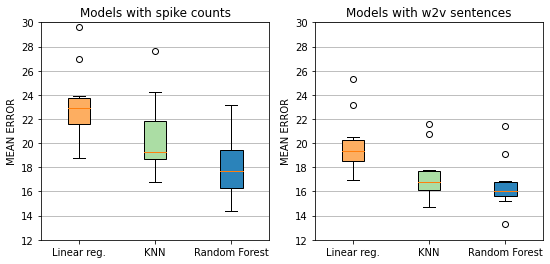

In [36]:
# PLOTS:
    
# https://matplotlib.org/stable/gallery/statistics/boxplot_color.html


labels = ['Linear reg.', 'KNN', 'Random Forest']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# Spike counts:
bplot1 = ax1.boxplot(df_rmse_te[['linreg_spikes', 'knn_spikes', 'rf_spikes']],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Models with spike counts')
ax1.set_ylabel('MEAN ERROR')

# Sentences:
bplot2 = ax2.boxplot(df_rmse_te[['linreg_sents', 'knn_sents', 'rf_sents']],
                     #notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Models with w2v sentences')

colors = ['#fdae61', '#abdda4', '#2b83ba']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# Horizontal gridlines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    # ax.set_xlabel('Models with spike counts')
    # ax.set_ylabel('Models with w2v sentences')
    ax.set_ylim(12, 30)

#plt.title('Mean errors over 10 folds')
plt.ylabel('MEAN ERROR')  
# plt.savefig("simple_models_rsmes.svg")
# plt.savefig("simple_models_rsmes.png")
# plt.savefig("simple_models_rsmes.jpg")


Combine all predictions of all models of each fold to dataframe (to make comparing them easier):

In [27]:
def make_single_preds_df(cols, is_spikes, dfs_orig):
    dfs_list = []
    for i, models_preds in enumerate(dfs_orig): # model
        for k in range(10): # fold
            fold_preds = models_preds[k]
            if i==0:
                if is_spikes==True:
                    df_preds_fold = fold_preds[['x', 'y']]
                else:
                    df_preds_fold = fold_preds[['sent', 'length', 'x', 'y']]
            else:
                df_preds_fold = dfs_list[k]
            model_name = cols[i].split('_')[0]
            df_preds_fold[model_name + "_x"] = fold_preds['pred_x']
            df_preds_fold[model_name + "_y"] = fold_preds['pred_y']
            df_preds_fold[model_name + "_dist"] = fold_preds['dist']  
            if i==0:
                dfs_list.append(df_preds_fold )
            else:
                dfs_list[k] = df_preds_fold      
    return dfs_list

In [28]:
pred_dfs_spikes = [pred_linreg_spikes, pred_knn_spikes, pred_rf_spikes]
pred_dfs_sents =  [pred_linreg_sents, pred_knn_sents, pred_rf_sents]
cols_spikes = ['linreg_spikes', 'knn_spikes', 'rf_spikes']
cols_sents = ['linreg_sents', 'knn_sents', 'rf_sents']

dfs_pred_spikes = make_single_preds_df(cols_spikes, True, pred_dfs_spikes)
dfs_pred_sents = make_single_preds_df(cols_sents, False, pred_dfs_sents)

C:\Users\renat\AppData\Local\Temp/ipykernel_17556/2269939825.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds_fold[model_name + "_x"] = fold_preds['pred_x']
C:\Users\renat\AppData\Local\Temp/ipykernel_17556/2269939825.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds_fold[model_name + "_y"] = fold_preds['pred_y']


In [31]:
# Example: df of sentences models of fold 0:
dfs_pred_sents[0][:5]

,sent,length,x,y,linreg_x,linreg_y,linreg_dist,knn_x,knn_y,knn_dist,rf_x,rf_y,rf_dist
0,"[35, 49, 4, 4, 4, 6, 6, 5, 20, 4, 56, 6, 55, 3...",86,52.171690,45.150960,44.240630,48.140888,8.475930,53.278613,52.124170,7.060520,49.382577,57.502042,12.662084
1,"[4, 35, 5, 55, 1, 49, 35, 35, 6, 6, 35, 35, 19...",88,46.543049,40.373398,44.501304,48.616396,8.492098,52.443910,52.267888,13.277765,49.421864,56.665527,16.544517
2,"[35, 4, 49, 4, 35, 4, 35, 35, 55, 4, 55, 1, 4,...",105,40.090321,35.661596,42.838413,48.583924,13.211304,52.903323,55.180361,23.348559,49.117442,57.061790,23.226219
3,"[20, 35, 4, 4, 15, 4, 4, 49, 56, 4, 5, 35, 52,...",103,36.007021,32.948307,44.084908,47.774432,16.883905,52.058908,56.549919,28.542935,49.323082,57.459932,27.895112
4,"[19, 4, 56, 6, 19, 5, 19, 49, 49, 35, 35, 55, ...",99,35.142944,32.040542,44.295923,46.493481,17.107440,51.326846,52.418515,26.022692,49.802494,57.792190,29.631905


**Save results:**

In [ ]:
with open(path_to_results + "dfs_preds_folds.plk", "wb") as fout:
    plk.dump([dfs_pred_spikes, dfs_pred_sents], fout) 

df_rmse_te.to_csv(path_to_results + "rmses_test.csv", sep=",", index=False, encoding="utf-8") 
df_rmse_tr.to_csv(path_to_results + "rmses_train.csv", sep=",", index=False, encoding="utf-8") 

**Load results:**

In [ ]:
# df_rmse_te = pd.read_csv(path_to_results + "rmses_test.csv", sep=",", encoding = "UTF-8") 
# df_rmse_tr = pd.read_csv(path_to_results + "rmses_train.csv", sep=",", encoding = "UTF-8") 

# with open(path_to_results + "dfs_preds_folds.plk", "rb") as fin:
#     loaded = plk.load(fin)
#     dfs_pred_spikes =loaded[0] 
#     dfs_pred_sents = loaded[1]